## Denetimsiz Yöntemlerle Siber Anomali Tespiti: UNSW-NB15 Uygulaması**




## 🔍 Amaç: Denetimsiz Anomali Tespiti ile Siber Saldırıların Belirlenmesi

Bu çalışmanın amacı, **UNSW-NB15** veri seti üzerinde, "normal" ve "attack" etiketleri **kullanılmadan**, yani **denetimsiz (unsupervised)** yöntemlerle ağ trafiği içerisindeki anormal davranışların tespit edilip edilemeyeceğini araştırmaktır.

Çoğu gerçek dünya senaryosunda siber saldırı verileri önceden etiketlenmiş olmayabilir. Bu nedenle etiketlere ihtiyaç duymadan anomali tespiti yapabilen yöntemlerin önemi oldukça büyüktür.

Bu kapsamda:
- Veri seti üzerinde gerekli ön işlemler uygulanacak,
- Özellik seçimi ve dönüştürme adımları gerçekleştirilecek,
- Farklı denetimsiz anomali tespit algoritmaları (örneğin: Isolation Forest, One-Class SVM, DBSCAN vb.) ile modellemeler yapılacak,
- Elde edilen sonuçlar, yalnızca analiz süreci sonunda referans olarak kullanılacak olan "label" sütunu ile kıyaslanarak değerlendirilecektir.

📌 Not: "label" sütunu yalnızca nihai değerlendirme metriklerinin hesaplanması amacıyla kullanılacaktır, model eğitim sürecine dahil edilmeyecektir.


##Veri Hazırlığı

In [ ]:
# Gerekli Kütüphaneler
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
file_path = "/content/drive/MyDrive/ml/6_hafta/dataset/UNSW_NB15_training-set.csv"
df = pd.read_csv(file_path)

Veri setimizi yükledik, şimdi içeriğine bir göz atalım.

In [ ]:
df.head(10) #!0 satır incelemeyi sevdiğim için burayı her zaman 10 olarak girerim ve öyle kullanırım.

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.09020,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.00030,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.00510,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.66080,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.00250,...,1,3,0,0,0,2,3,0,Normal,0
5,6,0.000003,udp,-,INT,2,0,784,0,333333.32150,...,1,2,0,0,0,2,2,0,Normal,0
6,7,0.000006,udp,-,INT,2,0,1960,0,166666.66080,...,1,2,0,0,0,2,2,0,Normal,0
7,8,0.000028,udp,-,INT,2,0,1384,0,35714.28522,...,1,3,0,0,0,1,3,0,Normal,0
8,9,0.000000,arp,-,INT,1,0,46,0,0.00000,...,2,2,0,0,0,2,2,1,Normal,0
9,10,0.000000,arp,-,INT,1,0,46,0,0.00000,...,2,2,0,0,0,2,2,1,Normal,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

Elimizde bazı kategorik değerler var fakat anomali testi yaparken yalnızca sayısal verilerle çalışmalıyız bunların droplayacağız.


In [ ]:
# Sayısal sütunları seçelim
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Etiket sütunu olan 'label'ı da alalım ki seçim yapabilelim
numeric_df['label'] = df['label']

numeric_df.shape


(82332, 41)

Burada label sütunu:

0 → Normal trafik

1 → Saldırı (Anomaly)

In [ ]:
# Normal ve saldırı örneklerini ayıralım
normal_samples = numeric_df[numeric_df['label'] == 0].sample(n=2000, random_state=42)
attack_samples = numeric_df[numeric_df['label'] == 1].sample(n=500, random_state=42)

# Bunları birleştirelim
sample_df = pd.concat([normal_samples, attack_samples], ignore_index=True)

# 'label' sütununu ayırıp sadece sayısal verilerle ilerleyeceğiz
X = sample_df.drop('label', axis=1)
y = sample_df['label']


İlk test için:

2000 normal örnek

500 saldırı örneği seçeceğiz

###  Neden Sadece Sayısal Sütunlar
Bu çalışmada sadece sayısal (numerik) özellikleri kullanıyoruz. Bunun birkaç nedeni var:

1.  **Kullandığımız algoritmalar sayısal verilerle çalışır:**
   - Isolation Forest, One-Class SVM, DBSCAN gibi denetimsiz öğrenme algoritmaları matematiksel işlemler (mesafe, dağılım gibi) yapar.
   - Bu işlemler sadece sayısal değerler üzerinde anlamlı sonuçlar üretir.

2.  **Kategorik veriler doğrudan kullanılamaz:**
   - Örneğin `proto = TCP`, `state = FIN` gibi değerler doğrudan modelin anlayabileceği bir formatta değildir.
   - Bu tür verileri dönüştürmek gerekir (örneğin one-hot encoding), ancak bu da veri setinin boyutunu çok artırabilir.

3.  **İlk adımda daha sade bir yapı istiyoruz:**
   - Başlangıçta yalnızca sayısal verilerle çalışmak modelin nasıl davrandığını anlamamızı kolaylaştırır.
   - Eğer iyi sonuç alırsak daha sonra kategorik verileri de eklemeyi düşünebiliriz.

 Bu nedenle bu aşamada sadece sayısal sütunlarla basit ama etkili bir başlangıç yapmalıyız.

##Ön İşleme

İlk olarak veri setinde eksik değer var mı onu kontrol edeceğiz. Varsa bunları temizleyeceğiz.

In [ ]:
# Eksik veri kontrolü
print("Eksik veri sayısı:\n", X.isnull().sum())



Eksik veri sayısı:
 id                   0
dur                  0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
dtype: int64


Bu veri seti siber saldırıları simüle ederek oluşturulduğu için genellikle eksik veri içermez. Fakat ben yine de kontrol etmek istedim ve göründüğü üzere eksik verimiz bulunmuyor.

Anomali tepsiti yapan algoritmalar mesafe tespiti yapyıkları için aslında ölçek farklılıklarına karşı hassastır bu sebeple tüm sayısal verileri belirli bir aralığa çekmek gerekir.
Bunun için standartlaştırma yapacağız ve StandartScaler kullanacağız.

In [ ]:
X = sample_df.drop(columns=["label", "id", "attack_cat"], errors="ignore")
y = sample_df["label"]

In [ ]:
# StandardScaler ile veriyi dönüştürelim
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Standartlaştırma işlemlerimizi de tamamladığımıza göre artık modellerle anomali tespiti yapmaya geçebiliriz

##DBSCAN Uygulaması


DBSCAN yoğunluk tabanlı bir kümeleme algoritmasıdır ve etiketsiz anomali tespitinde oldukça işe yarar. DBSCAN bazı noktaları “gürültü (noise)” olarak etiketler bunlar bizim için potansiyel anomali adaylarıdır.

Deneme amaçlı eps ve min samples parametrelerine bazı değerler verelim

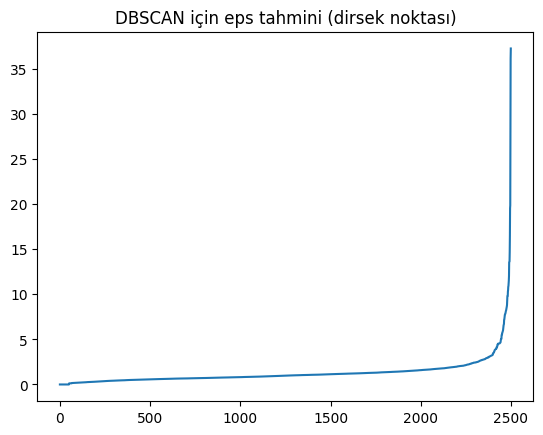

In [ ]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# En yakın komşuluk mesafesini çiz
distances = np.sort(distances[:,4])
plt.plot(distances)
plt.title("DBSCAN için eps tahmini (dirsek noktası)")
plt.show()

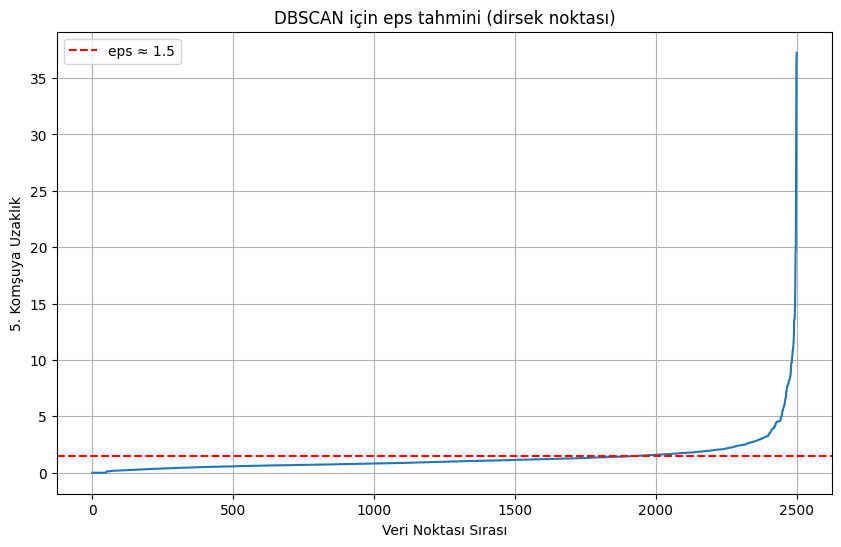

In [ ]:
# eps tahmini çizgisi ile birlikte k-distance plot
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.axhline(y=1.5, color='r', linestyle='--', label='eps ≈ 1.5')
plt.title("DBSCAN için eps tahmini (dirsek noktası)")
plt.xlabel("Veri Noktası Sırası")
plt.ylabel("5. Komşuya Uzaklık")
plt.legend()
plt.grid(True)
plt.show()

En iyi eps değerini bulmak için bit fonksiyon oluşturalım grafiklersen bir aralık tahmini yapıyoruz fakat tam kesin bir şey söyleyemeyiz bu sebeple buna uygun bir fonksiyon yazmak daha doğru bir yaklaşım olucak.

In [ ]:
from sklearn.metrics import silhouette_score

best_score = -1
for eps in [0.1, 0.5, 1.0, 1.5]:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X_scaled)
    if len(np.unique(labels)) > 1:  # En az 2 küme varsa
        score = silhouette_score(X_scaled, labels)
        if score > best_score:
            best_eps = eps
print("Best eps:", best_eps)

Best eps: 1.5


En uygun eps değerimiz 1.5 çıktı o zaman dbscani buna göre yapılandıralım.

In [ ]:
dbscan = DBSCAN(eps=1.5, min_samples=5)
db_preds = (dbscan.fit_predict(X_scaled) == -1).astype(int)

DBSCAN sonuçlarını 2 boyutta görmek için PCA ile boyut indirgeme yapacağız.

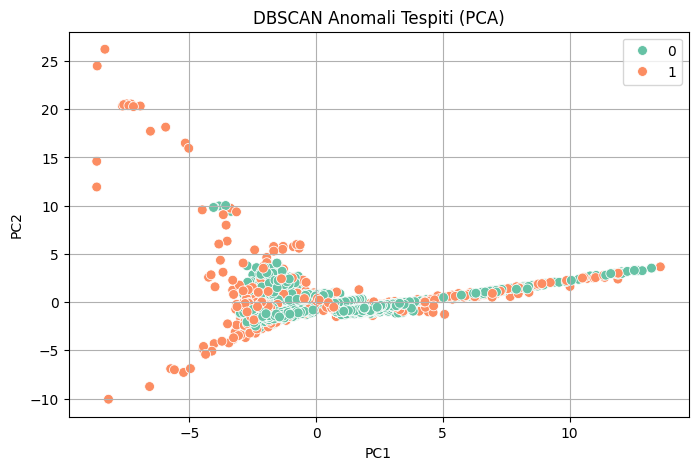

In [ ]:
# PCA ile 2 boyuta indir
X_pca = PCA(n_components=2).fit_transform(X_scaled)

# DBSCAN kümelerini görselleştir
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=db_preds, palette="Set2", s=50)
plt.title("DBSCAN Anomali Tespiti (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


Başarısını ölçmek amacıyla da confusion matrix ve sınıflandırma raporu oluşturalım

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix ve metrikler
print("Confusion Matrix:")
print(confusion_matrix(y, db_preds))

print("\nSınıflandırma Raporu:")
print(classification_report(y, db_preds, target_names=["Normal", "Attack"]))


Confusion Matrix:
[[1715  285]
 [ 390  110]]

Sınıflandırma Raporu:
              precision    recall  f1-score   support

      Normal       0.81      0.86      0.84      2000
      Attack       0.28      0.22      0.25       500

    accuracy                           0.73      2500
   macro avg       0.55      0.54      0.54      2500
weighted avg       0.71      0.73      0.72      2500



Anomaly detection yaptığımız için bizim için en önemli değer recall değeri ve raporumuza göre model gerçek saldırıların sadece %22 kadarını tespit edebilmiş. Bu durumda sampledaki normal ve attack olarak aldığımız 2000-500 değerleriyle biraz oynayarak daha doğru bir sonuca ulaşmaya çalışabiliriz

In [ ]:
"""
# Normal ve saldırı örneklerini ayıralım
normal_samples = numeric_df[numeric_df['label'] == 0].sample(n=2000, random_state=42)
attack_samples = numeric_df[numeric_df['label'] == 1].sample(n=1000, random_state=42)

# Bunları birleştirelim
sample_df = pd.concat([normal_samples, attack_samples], ignore_index=True)

# 'label' sütununu ayırıp sadece sayısal verilerle ilerleyeceğiz
X = sample_df.drop('label', axis=1)
y = sample_df['label']
"""

In [ ]:
"""
# StandardScaler ile veriyi dönüştürelim
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

"""

In [ ]:
"""
dbscan = DBSCAN(eps=2.0, min_samples=10)
db_preds = (dbscan.fit_predict(X_scaled) == -1).astype(int)
"""

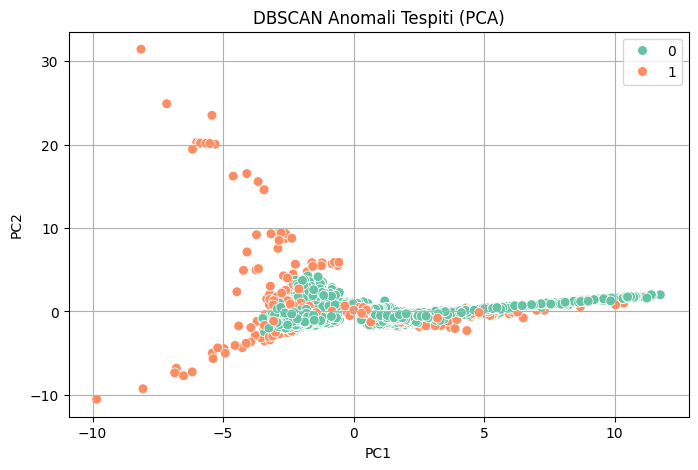

In [ ]:
"""
# PCA ile 2 boyuta indir
X_pca = PCA(n_components=2).fit_transform(X_scaled)

# DBSCAN kümelerini görselleştir
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=db_preds, palette="Set2", s=50)
plt.title("DBSCAN Anomali Tespiti (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()
"""

In [ ]:
"""
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix ve metrikler
print("Confusion Matrix:")
print(confusion_matrix(y, db_preds))

print("\nSınıflandırma Raporu:")
print(classification_report(y, db_preds, target_names=["Normal", "Attack"]))
"""

Confusion Matrix:
[[1777  223]
 [ 876  124]]

Sınıflandırma Raporu:
              precision    recall  f1-score   support

      Normal       0.67      0.89      0.76      2000
      Attack       0.36      0.12      0.18      1000

    accuracy                           0.63      3000
   macro avg       0.51      0.51      0.47      3000
weighted avg       0.57      0.63      0.57      3000



Recall değerimiz daha da düştü malesef o yüzden bu yöntem işe yaramadı eski kod satırlarını çalıştırarak onlar üzerinden ilerleyelim ama bu da bir deneyim olarak burada dursun.

##Isolation Forest Uygulaması

In [ ]:
# Isolation Forest
iso_model = IsolationForest(contamination=0.2, random_state=42)
iso_preds = (iso_model.fit_predict(X_scaled) == -1).astype(int)

In [ ]:
print(confusion_matrix(y, iso_preds))
print(classification_report(y, iso_preds))

[[1645  355]
 [ 355  145]]
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      2000
           1       0.29      0.29      0.29       500

    accuracy                           0.72      2500
   macro avg       0.56      0.56      0.56      2500
weighted avg       0.72      0.72      0.72      2500



Isolation Forest anomali tespiti için denetimsiz bir algoritmadır. Bu model, her örneği "normal" veya "anomali" olarak sınıflandırır ve contamination parametresi veri setindeki anomali oranını belirtir bu değeri 0.05 gibi küçük bir oranla ayarlayarak %5'lik bir anomali oranı olduğunu varsayabiliriz.
Not: Biz sample değerlerimizi bildiğimi ve 0.2 değerine karşılık geldiklerinin de farkıında olduğumuz için en optimalini aslında 0.2 verecektir.

In [ ]:
iso_model = IsolationForest(contamination=0.05, random_state=42)
iso_preds = (iso_model.fit_predict(X_scaled) == -1).astype(int)

In [ ]:
print(confusion_matrix(y, iso_preds))
print(classification_report(y, iso_preds))

[[1923   77]
 [ 452   48]]
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      2000
           1       0.38      0.10      0.15       500

    accuracy                           0.79      2500
   macro avg       0.60      0.53      0.52      2500
weighted avg       0.72      0.79      0.73      2500



Recall değerimiz bir hayli düştü bu da demektir ki isolation forest kullanırken dorğu contamination değeri en öneli şeydir.

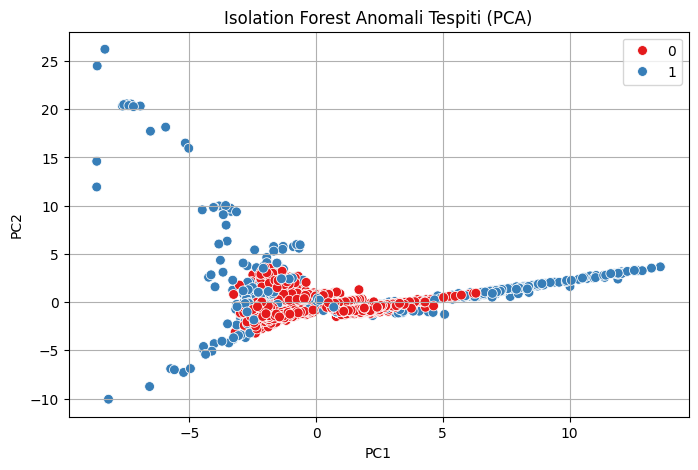

In [ ]:
# Isolation Forest grafiği
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=iso_preds, palette="Set1", s=50)
plt.title("Isolation Forest Anomali Tespiti (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [ ]:
# Isolation Forest
iso_model = IsolationForest(contamination=0.2, random_state=42)
iso_preds = (iso_model.fit_predict(X_scaled) == -1).astype(int)
print(confusion_matrix(y, iso_preds))
print(classification_report(y, iso_preds))

[[1645  355]
 [ 355  145]]
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      2000
           1       0.29      0.29      0.29       500

    accuracy                           0.72      2500
   macro avg       0.56      0.56      0.56      2500
weighted avg       0.72      0.72      0.72      2500



Gözlemlediğimiz gibi, Isolation Forest modelinde attack sınıfının recall değeri oldukça düşük (0.29), bu da modelin çoğu saldırıyı tespit edemediğini gösteriyor. Ancak normal sınıfı üzerinde başarı oranı (precision, recall) oldukça yüksek. Bu, modelin çoğunlukla normal verileri doğru sınıflandırdığını, ancak anomali tespitinde (attack) başarısız olduğunu gösteriyor.

##Karşılaştırma

Son olarak iki farklı anomali tespit yönteminin performansları karşılaştırılacağız DBSCAN ve Isolation Forest. DBSCAN yoğunluk tabanlı kümeleme yaklaşımı kullanırken Isolation Forest karar ağaçlarıyla anomali tespiti yapar her iki yöntem de denetimsiz öğrenme teknikleri olarak kullanılsa da farklı parametre ayarları ve veri yapıları nedeniyle sonuçlarda farklılıklar gözlemlenebilir(büyük ihtimalle)

In [ ]:
print("=== DBSCAN ===")
print(confusion_matrix(y, db_preds))
print(classification_report(y, db_preds))

print("\n=== Isolation Forest ===")
print(confusion_matrix(y, iso_preds))
print(classification_report(y, iso_preds))

=== DBSCAN ===
[[1715  285]
 [ 390  110]]
              precision    recall  f1-score   support

           0       0.81      0.86      0.84      2000
           1       0.28      0.22      0.25       500

    accuracy                           0.73      2500
   macro avg       0.55      0.54      0.54      2500
weighted avg       0.71      0.73      0.72      2500


=== Isolation Forest ===
[[1645  355]
 [ 355  145]]
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      2000
           1       0.29      0.29      0.29       500

    accuracy                           0.72      2500
   macro avg       0.56      0.56      0.56      2500
weighted avg       0.72      0.72      0.72      2500



**Sonuç olarak**,

**DBSCAN** yoğunluk bazlı olduğu için bazı saldırıların düşük yoğunluklu olmasından dolayı kaçırabilir ama **Isolation Forest**, verilerin izole edilebilirliğini dikkate alarak anomali tespiti yapar bu da saldırıları daha iyi tespit etmesini sağlar. Yine de her iki modelde de eksiklikler var. Belki de bu iki algoritmanın sonuçlarını birleştirip daha güçlü bir model oluşturmak saldırıları daha iyi tespit etmek için etkili olabilir.